In [1]:
# Install standard Python libraries
!pip install pandas
!pip install scikit-learn
!pip install xgboost
!pip install joblib

In [2]:

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from xgboost import XGBRegressor
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# Load data using Pandas
train_df = pd.read_csv('/content/drive/MyDrive/INTEL_AI/PM_train.txt', sep=" ", header=None).dropna(axis=1)
test_df = pd.read_csv('/content/drive/MyDrive/INTEL_AI/PM_test.txt', sep=" ", header=None).dropna(axis=1)
truth_df = pd.read_csv('/content/drive/MyDrive/INTEL_AI/PM_truth.txt', sep=" ", header=None).dropna(axis=1)

# Preprocessing
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]
train_df.columns = cols_names
test_df.columns = cols_names
truth_df.columns = ['additional_rul']

train_df['RUL'] = train_df.groupby('id')['cycle'].transform('max') - train_df['cycle']
rul = test_df.groupby('id')['cycle'].max().reset_index()
rul.columns = ['id', 'max_cycle']
truth_df['id'] = truth_df.index + 1
truth_df = truth_df.merge(rul, on='id', how='left')
truth_df['RUL'] = truth_df['max_cycle'] + truth_df['additional_rul']
test_df = test_df.merge(truth_df[['id', 'RUL']], on='id', how='left')
test_df['RUL'] = test_df['RUL'] - test_df['cycle']

# Parallelized feature scaling
features = [col for col in cols_names if col not in ['id', 'cycle', 'RUL']]
scaler = StandardScaler()

def scale_data(df):
    df[features] = scaler.fit_transform(df[features])
    return df

train_df, test_df = Parallel(n_jobs=-1)(delayed(scale_data)(df) for df in [train_df, test_df])

# Prepare data for training and testing
X = train_df[features].values
y = train_df['RUL'].values
X_test = test_df[features].values
y_test = test_df['RUL'].values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train standard XGBoost model
xgb_model = XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.05, subsample=0.8)
train_start = time.time()
xgb_model.fit(X_train, y_train)
train_time_standard = time.time() - train_start
print(f"Training Time with Standard Libraries and Parallel Processing: {train_time_standard:.2f} seconds")

Training Time with Standard Libraries and Parallel Processing: 3.30 seconds


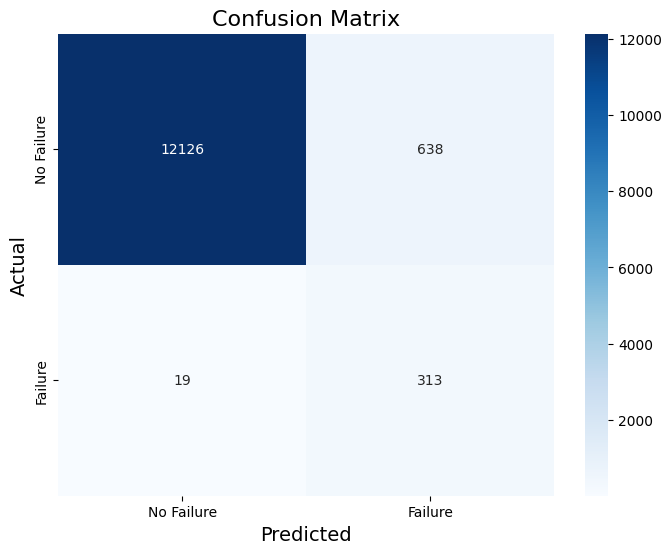

In [5]:

# Predict RUL on validation and test data
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

# Define a threshold for binary classification (e.g., w1 = 30 cycles)
w1 = 30
y_test_binary = (y_test <= w1).astype(int)  # Actual test labels
y_test_pred_binary = (y_test_pred <= w1).astype(int)

# Print Confusion Matrix for Binary Predictions
conf_matrix = confusion_matrix(y_test_binary, y_test_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()